In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [2]:
train = pd.read_csv('expanded', delimiter='\t', header=None, names=['characteristics'])
train = train['characteristics'].str.split(',', expand=True)
train = train.drop(range(7)).reset_index(drop=True)

In [3]:
# implement descriptive column names
column_names = ['edibility','cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat']
train.columns = column_names
train = train.drop(train[train.isnull().any(axis=1)].index)
train.head()

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [4]:
# get dummy variables for two-level response
def var_transform (data):
    data['edibility']=data['edibility'].apply(lambda x: 1 if x=='EDIBLE' else 0)
    data['odor']=data['odor'].apply(lambda x: 0 if x=='ALMOND' or x=='ANISE' else 1)
    # put further variable transformation here 
    return data

In [5]:
var_transform(train).head(2)

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,CONVEX,SMOOTH,WHITE,BRUISES,0,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,1,CONVEX,SMOOTH,WHITE,BRUISES,0,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [6]:
#Creating training and test datasets
np.random.seed(2)
splitted_train = train.sample(round(train.shape[0]*0.8))
test = train.drop(splitted_train.index)
train = splitted_train

In [7]:
print(train.shape)
print(test.shape)

(6733, 23)
(1683, 23)


In [38]:
train.gill_size.value_counts()

BROAD     4702
NARROW    2031
Name: gill_size, dtype: int64

In [39]:
train.habitat.value_counts()

WOODS      2520
GRASSES    1944
PATHS       922
LEAVES      681
URBAN       290
MEADOWS     228
WASTE       148
Name: habitat, dtype: int64

In [40]:
train.population.value_counts()

SEVERAL      3247
SOLITARY     1371
SCATTERED    1109
ABUNDANT      411
NUMEROUS      322
CLUSTERED     273
Name: population, dtype: int64

In [41]:
train.cap_shape.value_counts()

CONVEX     3076
FLAT       2605
KNOBBED     670
BELL        354
SUNKEN       25
CONICAL       3
Name: cap_shape, dtype: int64

In [46]:
train.bruises.value_counts()

NO         4048
BRUISES    2685
Name: bruises, dtype: int64

In [128]:
X1 = train[['odor','habitat','gill_size','population','bruises']]
X2 = train[['habitat','gill_size','population','bruises','gill_spacing','cap_surface','cap_color']]
X = train[['habitat','population','gill_size','bruises','gill_spacing','cap_surface','cap_color','ring_number','veil_type','stalk_surface_above_ring','gill_spacing','gill_attachment']]

- Most variables DO NOT work independenly or when adding on top another predictor. We might need futher feature engineering to get the problem solved.

In [129]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit(formula = 'edibility~'+ '+'.join(predictor_subset), data = train).fit()
    #calculate accuracy
    pred_values = model.predict(train)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(train.edibility, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()

    return {"model":model, "accuracy":accuracy}

In [130]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [131]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["accuracy", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

         Current function value: 0.582508
         Iterations: 35
         Current function value: 0.543111
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.531600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603369
         Iterations 7
         Current function value: 0.668321
         Iterations: 35
         Current function value: inf
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWa

LinAlgError: Singular matrix

# Forward selection

In [136]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest classification accuracy
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [137]:
def forward_selection():
    models_best = pd.DataFrame(columns=["accuracy", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [138]:
models_best = forward_selection()

         Current function value: 0.582508
         Iterations: 35
         Current function value: 0.543111
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.531600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603369
         Iterations 7
         Current function value: 0.668321
         Iterations: 35
         Current function value: inf
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWa

LinAlgError: Singular matrix

# Model Performance

In [13]:
#Function to compute confusion matrix and prediction accuracy
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [96]:
#model=sm.logit(formula='edibility~cap_shape+cap_surface+cap_color+bruises+gill_spacing+gill_size+stalk_color_above_ring',data=train).fit() 
#model.summary()

In [ ]:
column = ['edibility','cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat']

In [169]:
model_ma = sm.logit(formula = 'edibility~habitat+population+gill_size+bruises+gill_spacing+cap_surface+cap_color+ring_number+veil_type+gill_spacing+stalk_surface_above_ring+gill_attachment', data = train).fit()
model_max.summary()

         Current function value: 0.081606
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              edibility   No. Observations:                 6733
Model:                          Logit   Df Residuals:                     6700
Method:                           MLE   Df Model:                           32
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.8818
Time:                        15:22:42   Log-Likelihood:                -549.46
converged:                      False   LL-Null:                       -4648.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             22.3686   3.41e+05   6.56e-05      1.000   -6.69e+05    6.69e+05
habitat[T.LEAVES]                     -0.7751      0.557     -1.391      0.164      -1.867       0.317
habitat[T.MEADOWS]                     0.7879      0.368      2.142      0.032       0.067       1.509
habitat[T.PATHS]                      -1.0382      0.414     -2.507      0.012      -1.850      -0.227
habitat[T.URBAN]                       0.8125      0.301      2.696      0.007       0.222       1.403
habitat[T.WASTE]                      73.2672      1e+05      0.001      0.999   -1.96e+05    1.96e+05
habitat[T.WOODS]                      -0.3493      0.301     -1.161      0.246      -0.939       0.240
population[T.CLUSTERED]              -55.5621   1.01e+05     -0.001      1.000   -1.99e+05    1.99e+05
population[T.NUMEROUS]                 9.7820   2.25e+05   4.35e-05      1.000   -4.41e+05    4.41e+05
population[T.SCATTERED]              -19.5632    1.6e+04     -0.001      0.999   -3.14e+04    3.14e+04
population[T.SEVERAL]                -20.3130    1.6e+04     -0.001      0.999   -3.14e+04    3.14e+04
population[T.SOLITARY]               -17.2896    1.6e+04     -0.001      0.999   -3.14e+04    3.14e+04
gill_size[T.NARROW]                   -6.4452      0.372    -17.309      0.000      -7.175      -5.715
bruises[T.NO]                         -0.2621      0.320     -0.818      0.413      -0.890       0.366
gill_spacing[T.CROWDED]                7.2945      0.419     17.399      0.000       6.473       8.116
cap_surface[T.GROOVES]                 3.9094   6.47e+05   6.05e-06      1.000   -1.27e+06    1.27e+06
cap_surface[T.SCALY]                  -1.3854      0.285     -4.860      0.000      -1.944      -0.827
cap_surface[T.SMOOTH]                 -4.1487      0.331    -12.526      0.000      -4.798      -3.500
cap_color[T.BUFF]                    -24.6596   2805.115     -0.009      0.993   -5522.584    5473.265
cap_color[T.CINNAMON]                 15.2596   1336.529      0.011      0.991   -2604.289    2634.808
cap_color[T.GRAY]                     -1.6991      0.331     -5.140      0.000      -2.347      -1.051
cap_color[T.GREEN]                    11.3852     27.107      0.420      0.674     -41.743      64.514
cap_color[T.PINK]                     -8.3993      0.654    -12.833      0.000      -9.682      -7.117
cap_color[T.PURPLE]                   24.5644   2.13e+04      0.001      0.999   -4.17e+04    4.18e+04
cap_color[T.RED]                      -0.5093      0.406     -1.256      0.209      -1.304       0.286
cap_color[T.WHITE]                    -2.5047      0.363     -6.910      0.000      -3.215      -1.794
cap_color[T.YELLOW]                   -0.7253      0.415     -1.749      0.080      -1.538       0.088
ring_number[T.ONE]                    57.7463   3.26e+05      0.000      1.000   -6.38e+05    6.38e+05
ring_number[T.TWO]                    59.9942   

In [187]:
model = sm.logit(formula = 'edibility~population+gill_size+bruises+cap_surface+cap_color+ring_number+stalk_surface_above_ring+gill_spacing+gill_attachment', data = train).fit()
model.summary()

         Current function value: 0.088104
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              edibility   No. Observations:                 6733
Model:                          Logit   Df Residuals:                     6706
Method:                           MLE   Df Model:                           26
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.8724
Time:                        15:23:49   Log-Likelihood:                -593.21
converged:                      False   LL-Null:                       -4648.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            -83.2605   3.68e+06  -2.26e-05      1.000   -7.22e+06    7.22e+06
population[T.CLUSTERED]              -30.7903        nan        nan        nan         nan         nan
population[T.NUMEROUS]                -6.0245        nan        nan        nan         nan         nan
population[T.SCATTERED]              -34.9038        nan        nan        nan         nan         nan
population[T.SEVERAL]                -35.9498        nan        nan        nan         nan         nan
population[T.SOLITARY]               -32.2112        nan        nan        nan         nan         nan
gill_size[T.NARROW]                   -6.4030      0.354    -18.103      0.000      -7.096      -5.710
bruises[T.NO]                         -0.4682      0.296     -1.582      0.114      -1.048       0.112
cap_surface[T.GROOVES]               -35.4660   3.72e+05  -9.54e-05      1.000   -7.29e+05    7.29e+05
cap_surface[T.SCALY]                  -2.0625      0.286     -7.209      0.000      -2.623      -1.502
cap_surface[T.SMOOTH]                 -3.9518      0.311    -12.691      0.000      -4.562      -3.342
cap_color[T.BUFF]                     -8.5849      0.809    -10.617      0.000     -10.170      -7.000
cap_color[T.CINNAMON]                 69.0097   4.91e+11    1.4e-10      1.000   -9.63e+11    9.63e+11
cap_color[T.GRAY]                     -2.1462      0.325     -6.609      0.000      -2.783      -1.510
cap_color[T.GREEN]                    14.8395    161.048      0.092      0.927    -300.809     330.488
cap_color[T.PINK]                     -8.8104      0.646    -13.635      0.000     -10.077      -7.544
cap_color[T.PURPLE]                   22.7971   9298.245      0.002      0.998   -1.82e+04    1.82e+04
cap_color[T.RED]                      -0.9461      0.383     -2.469      0.014      -1.697      -0.195
cap_color[T.WHITE]                    -3.0451      0.356     -8.564      0.000      -3.742      -2.348
cap_color[T.YELLOW]                   -1.3986      0.400     -3.495      0.000      -2.183      -0.614
ring_number[T.ONE]                   185.5483   3.08e+06   6.02e-05      1.000   -6.04e+06    6.05e+06
ring_number[T.TWO]                   189.0090   3.08e+06   6.13e-05      1.000   -6.04e+06    6.05e+06
stalk_surface_above_ring[T.SCALY]     -5.1479      0.850     -6.056      0.000      -6.814      -3.482
stalk_surface_above_ring[T.SILKY]     -7.6550      0.567    -13.503      0.000      -8.766      -6.544
stalk_surface_above_ring[T.SMOOTH]     2.8967      0.391      7.408      0.000       2.130       3.663
gill_spacing[T.CROWDED]                6.4892      0.347     18.710      0.000       5.809       7.169
gill_attachment[T.FREE]              -63.0077        nan        nan        nan         nan         nan
======================================================================================================

Possibly complete quasi-separation: A fraction 

Classification accuracy = 97.1%
Precision = 97.0%
TPR or Recall = 97.7%
FNR = 2.3%
FPR = 3.5%
ROC-AUC = 99.4%


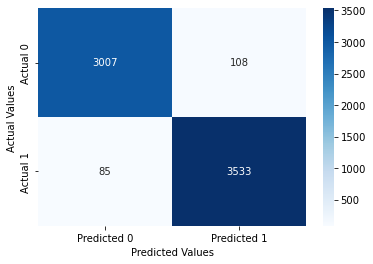

In [188]:
confusion_matrix_data(train,train.edibility,model,0.5)

# Ridge Regression

In [20]:
#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5